# How to Control Diffusion Model
![](https://www.casualganpapers.com/assets/images/GLIDE_preview.png)
- Classifier guided: Diffusion Models Beat GANs on Image Synthesis
- Classifier-free: Classifier-Free Diffusion Guidance
- PnP: Diffusion Models as Plug-and-Play Priors 

## Classifier Guided Diffusion
論文p. 26 eq 55
$$ p_{\theta,\phi}(x_t|x_{t+1},y) = Z \cdot p_{\theta}(x_t|x_{t+1})p_{\phi}(y|x_t) $$  
Diffusion性質
$$p_{\theta}(x_t|x_{t+1}) = \mathcal{N}(\mu, \Sigma)$$
$$log p_{\theta}(x_t|x_{t+1}) = -\frac{1}{2} (x_t - \mu)^T \Sigma^{-1} (x_t - \mu) + C$$
step → 0 = ||Σ|| → 0. Taylor expansion around $x_t = \mu $
$$\log p_{\phi}(y|x_t) \approx \log p_{\phi}(y|x_t)|_{x_t = \mu} + (x_t - \mu)\nabla{x_t} \log p_{\phi}(y|x_t)|_{x_t = \mu} = (x_t - \mu)g + C_1 $$
$$g = \nabla_{x_t} \log p_{\phi}(y|x_t)|_{x_t = \mu}$$

$$    \log(p_{\theta}(x_t|x_{t+1}) p_{\phi}(y|x_t)) \approx \log p(z) + C_4, z \sim \mathcal{N}(\mu + \Sigma g, \Sigma)$$

***Conditional transition operator can be approximated by a
Gaussian similar to the unconditional transition operator, but with its mean shifted by Σg***

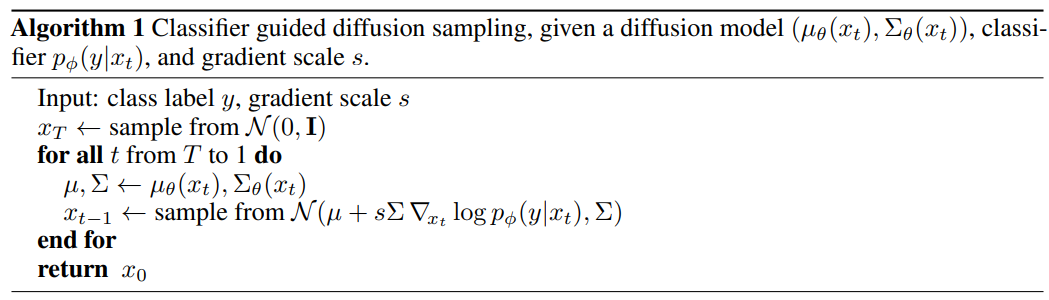
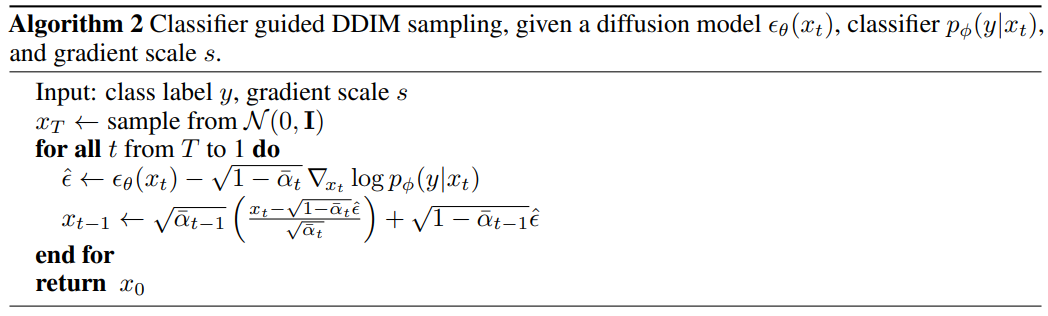

Ref: https://github.com/openai/guided-diffusion

```python
def cond_fn(x, t, y=None):
    assert y is not None
    with th.enable_grad():
        x_in = x.detach().requires_grad_(True)
        logits = classifier(x_in, t)
        log_probs = F.log_softmax(logits, dim=-1)
        selected = log_probs[range(len(logits)), y.view(-1)]
        return th.autograd.grad(selected.sum(), x_in)[0] * args.classifier_scale

def p_sample(
        self,
        model,
        x,
        t,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
    ):
    out = self.p_mean_variance(
        model,
        x,
        t,
        clip_denoised=clip_denoised,
        denoised_fn=denoised_fn,
        model_kwargs=model_kwargs,
    )
    noise = th.randn_like(x)
    nonzero_mask = (
        (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
    )  # no noise when t == 0
    if cond_fn is not None:
        out["mean"] = self.condition_mean(
            cond_fn, out, x, t, model_kwargs=model_kwargs
        )
    sample = out["mean"] + nonzero_mask * th.exp(0.5 * out["log_variance"]) * noise
    return {"sample": sample, "pred_xstart": out["pred_xstart"]}

def condition_mean(self, cond_fn, p_mean_var, x, t, model_kwargs=None):
    """
    Compute the mean for the previous step, given a function cond_fn that
    computes the gradient of a conditional log probability with respect to
    x. In particular, cond_fn computes grad(log(p(y|x))), and we want to
    condition on y.
    This uses the conditioning strategy from Sohl-Dickstein et al. (2015).
    """
    gradient = cond_fn(x, self._scale_timesteps(t), **model_kwargs)
    new_mean = (
        p_mean_var["mean"].float() + p_mean_var["variance"] * gradient.float()
    )
    return new_mean
```


![](https://benanne.github.io/images/classifier_guidance.jpg)

## Classifier-Free Diffusion
$$\nabla \log p(y|x_t) = \nabla \log p(x_t|y) − \nabla \log p(x_t)$$
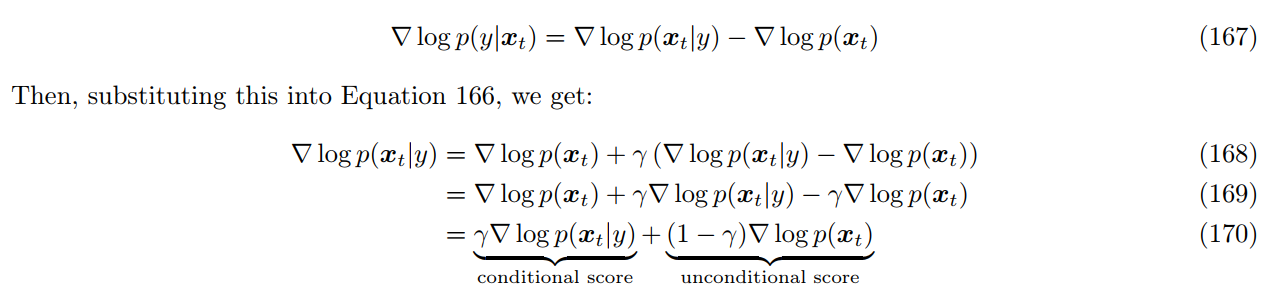
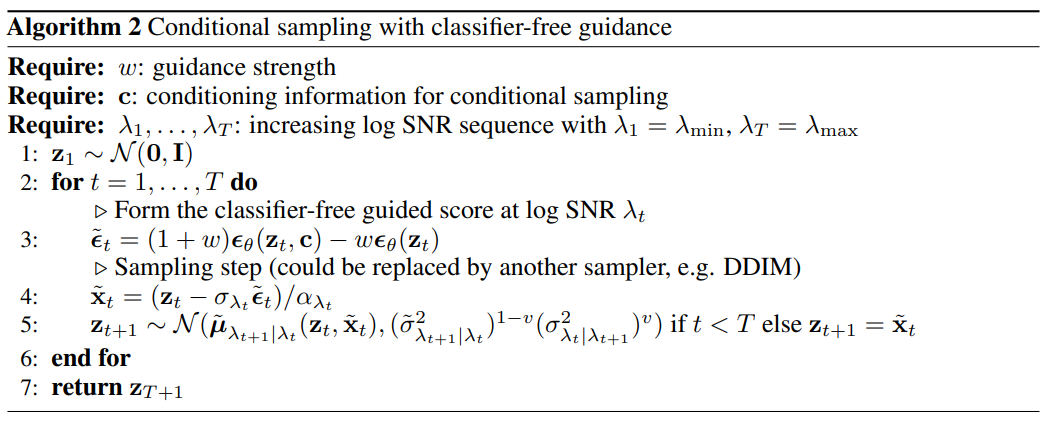
```python
 for t in range(T - 1, 0, -1):
    if get_intermediate_steps:
        steps.append(z_t)
    t = torch.LongTensor([t] * batch_size).to(self.device).view(-1, 1)
    t_expanded = t.view(-1, 1, 1, 1)
    if is_c_none:
        # compute unconditioned noise
        eps = self(z_t, t / T, c)  # predict via nn the noise
    else:
        # compute class conditioned noise
        eps1 = (1 + self.w) * self(z_t, t / T, c)
        eps2 = self.w * self(z_t, t / T, c * 0)
        eps = eps1 - eps2
    alpha_t = self.alphas[t_expanded]
    z = torch.randn_like(z_t)
    alpha_hat_t = self.alphas_hat[t_expanded]
    # denoise step from x_t to x_{t-1} following the DDPM paper
    z_t = (z_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * eps) / (torch.sqrt(alpha_t)) + \
            self.betas[t_expanded] * z
```


![](https://benanne.github.io/images/panda3.jpg)

## PnP Diffusion
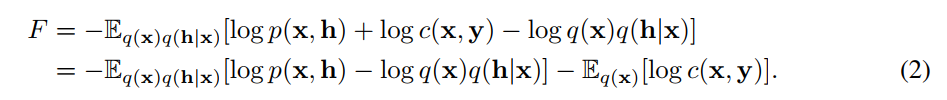
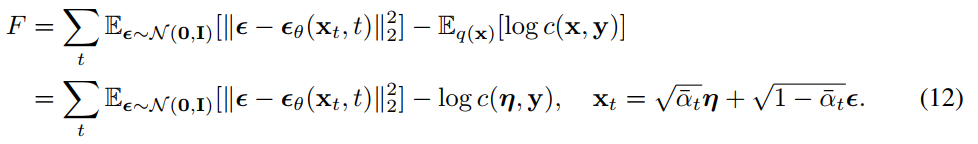



Ref: https://github.com/AlexGraikos/diffusion_priors

```python
# Train classifier
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 2, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 2, 1)
        self.out = nn.Linear(4*4*32, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.out(x.flatten(1))
        
        return torch.sigmoid(x)
    
# Inference Model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.img = nn.Parameter(torch.randn(1,1,32,32))
        self.img.requires_grad = True
                
    def encode(self):
        return self.img
    
model = Model().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
net.train()
class_net.train()

steps = 1000
bar = tqdm.tqdm(range(steps))
losses = []
update_every = 50
for i, _ in enumerate(bar):
    sample_img = model.encode()
   
    # Select t
    t = ((steps-i) + (steps-i)//4*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine
    t = np.array([t]).astype(int)
    t = np.clip(t, 1, diffusion.T)
    
    # Denoise
    xt, epsilon = diffusion.sample(sample_img, t)       
    t = torch.from_numpy(t).float().view(sample_img.shape[0])
    epsilon_pred = net(xt.float(), t.to(device))

    # Learned condition
    sample_img_clipped = torch.clip(sample_img, -1, 1)
    class_loss = class_net(sample_img_clipped).mean()

    # Denoising loss + aux loss
    loss = F.mse_loss(epsilon_pred, epsilon) + 0.01*(steps-i)/steps*class_loss
    
    # Update
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    if i % update_every == 0:
        bar.set_postfix({'Loss': np.mean(losses)})
        losses = []

    # Visualize sample
    if (i+1) % 100 == 0 or i == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.imshow(model.encode()[0].detach().cpu().numpy().transpose([1,2,0]), vmin=-1, vmax=1)
            ax.set_title('Inferred sample')
            plt.show()
```


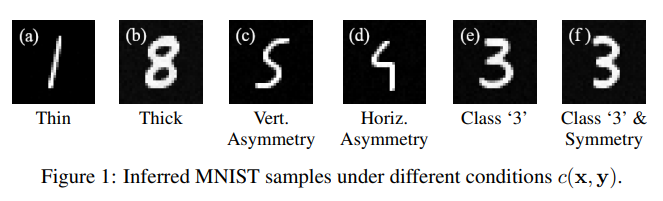